# 1. Imports & Definitions

## 1.1. Master

Imports

In [17]:
''' imports '''

import numpy as np
import pandas as pd

from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os, re, logging

%matplotlib widget
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

import pickle, random

# density clustering using HDBSCAN* algorithm
#import hdbscan

# dimensionality reduction using UMAP
#import umap

''' torch imports '''

import torch, math

from torch import nn
from torch import optim
from torch.distributions import Normal

import glob
from PIL import Image
import matplotlib.animation as animation

import json

#import torchsde, torchcde



''' init shjnn dev env '''

# set auto reload imported modules
%load_ext autoreload
%autoreload 2

import os
# create save and gif folders if they dont exist already
if not os.path.exists('./saves/'):
    os.makedirs('./saves/')
if not os.path.exists('./gifs/'):
    os.makedirs('./gifs/')

# add location to path
import sys
sys.path.append('../libs/')

import shjnn
import time
import ffmpeg

import matplotlib.dates as mdates

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

Dataloader


In [18]:
def dataloader(data_out):

    """
    Load raw data from file, map parameters to dimension data, compile lists of parameters, and generate full single-sample dataset.
    args: None
    returns: trajs, times, y
    """
    # decide whether to filter data before t=0
    filter = data_out['cut_zero']
    
    ## load raw data from file

    # open binary file for reading
    with open('{}/{}'.format('../run/', 'raw-full'), 'rb') as file:

        # load pickled data storage array
        db = pickle.load(file)


    ## parameter mappings to dimension data

    val_map = {
        # sample id to thickness in nm
        'thickness': {'source': 'sample',
                    '12': 160, '16': 160, '21': 160, '33': 160, '45': 160, '58': 160, },
        # intensity in uJ
        'intensity': {'source': 'int',
                    'dark': 0., '32uJ': 32., '10uJ': 10., '3uJ': 3., '1uJ': 1., '03uJ': .3},
        # voltage in V
        'voltage': {'source': 'vlt',
                    '05V': .5, '0V': 0., '15V': 1.5, '1V': 1., '2V': 2.},
        # delay time in log10(s)
        'delay': {'source': 'del',
                '100ns': 1e-7, '100us': 1e-4, '10ms': 1e-2, '10us': 1e-5, '1ms': 1e-3, '1us': 1e-6,
                '200ns': 2e-7, '200us': 2e-4, '20ms': 2e-2, '20us': 2e-5, '2ms': 2e-3, '2us': 2e-6,
                '500ns': 5e-7, '500us': 5e-4, '50ms': 5e-2, '50us': 5e-5, '5ms': 5e-3, '5us': 5e-6,
                },
    }

    ''' generate properties data '''

    # iterate nodes in database
    for node in db[:]:
        
        props = {}
        
        # iterate value mapping
        for key, value in val_map.items():
        
            # check node params for value
            if value['source'] in node['params'].keys():
                
                # map param to prop value
                props[key] = value[ node['params'][ value['source'] ] ]
                            
            else:
                # store zero for no match
                props[key] = 0.
                
        # store props in node
        node['props'] = props
    ''' generate properties data '''

    # iterate nodes in database
    for node in db[:]:
        
        props = {}
        
        # iterate value mapping
        for key, value in val_map.items():
        
            # check node params for value
            if value['source'] in node['params'].keys():
                
                # map param to prop value
                props[key] = value[ node['params'][ value['source'] ] ]
                            
            else:
                # store zero for no match
                props[key] = 0.
                
        # store props in node
        node['props'] = props

    ''' compile lists params '''

    # compile list samples
    smpls = sorted(list(set([ _['params']['sample'] for _ in db ])))
    print( 'smpls', smpls )

    # compile list voltages
    vlts = sorted(list(set([ _['props']['voltage'] for _ in db ])))
    print( 'vlts', vlts )

    # compile list voltages
    ints = sorted(list(set([ _['props']['intensity'] for _ in db ])))
    print( 'ints', ints )

    # complete list delays
    #dels = sorted(list(set([ _['props']['delay'] for _ in db ])))[1::]
    # restricted delay set
    dels = sorted(list(set([ _['props']['delay'] for _ in db ])))[1::3]
    print( 'dels', dels )

    
    ''' get full single-sample dataset '''

    # select transient conditions
    _smpl = '33'
    #_int = '10uJ'
    #_vlt = '15V'
    #_del = '10us'

    _db = [ n for n in db if
        n['params']['sample'] == _smpl and
        n['props']['delay'] != 0.
        #n['params']['int'] == _int and
        #n['params']['vlt'] == _vlt and
        #n['params']['del'] == _del
        ]

    print(len(_db))


    # initialise figure
    fig = plt.figure(figsize = (8,6))
    #axs = [[ fig.add_subplot(v,h,i+1) for i in range(h*v) ] for h,v in [(2,1)]][0]
    axs = [[ fig.add_subplot(v,h,i+1) for i in range(h*v) ] for h,v in [(1,1)]][0]

    # colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(_db[::10])); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'viridis')

    # zero baseline
    axs[0].plot([1e-8, 1e-4], [0,0], '--k')


    for i, n in enumerate(_db[::10]):
        
        # get time axis
        t = n['data'][:,0]
        d = n['data'][:,1]/50.
        #d0 = dark0['data'][:,1]#/50.
        #ds = d-d0

        c = smap.to_rgba(i)

        #print(light['params']['del'])

        #np.power(10,val_map['delay'][light['params']['del']])
        #sub = np.vstack([dark[:,0], (light[:,1] - dark[:,1])/50. ]).T

        #l = light['data'][:,1]#/50.
        #s = l-d

        # calculate current transient, illuminated less dark transient, voltage over 50 Ohm res
        #a = (light[:,1] - dark[:,1])/50.

        # smooth and calculate derivatives
        a = savgol_filter(x = d, window_length = 5, polyorder = 1, deriv = 0)

        _ds = 10
        
        # plot data
        axs[0].plot(t[::_ds], d[::_ds], '.', alpha = 0.2, color = c, linewidth = 2)
        axs[0].plot(t[::_ds], a[::_ds], '-', alpha = 0.44, color = c, linewidth = 1, label = ''.format())


        #axs[1].plot(t, da, '-', alpha = 0.7, color = c, linewidth = 1, label = '{}'.format(light['params']['int']))

            
    # format plots
    for i in range(len(axs)):
        axs[i].set_xscale('log')
        axs[i].set_xlim(1.0e-8, 1.0e-4)
        #axs[i].set_xlim(2.0e-7, 1.0e-4)
        
        #axs[i].set_ylim(0., 1.0e-2)
        axs[i].set_xlabel('Extraction Time (s)')
        axs[i].set_ylabel('Extracted Charge (A)')
        #axs[i].legend(title='Illumination')
        
    plt.tight_layout()
    plt.show()

    if filter:
        # filter data to only include non-zero delay times
        j = np.where(_db[0]['data'][:,0] > 2e-7)[0]

        # get log time steps, shift decay start to zero
        d = np.transpose( np.stack([ [ 
        # np.log10(n['data'][j,0][::_ds]), # time

        n['data'][j,1][::_ds]*1e2, # response, scale to ~one
        #np.log10(n['data'][j,0][::_ds])+6.6,

        #np.ones(len(ts))* np.log10(n['props']['intensity']),
        #np.ones(len(ts))* n['props']['voltage']/10,
        #np.ones(len(ts))* np.abs(np.log10(n['props']['delay']))/10,
        ]
        #for n in _db ]), (2,0,1))
        for n in _db ]), (0,2,1))
        
        # compile env. labels
        ts = np.transpose( np.stack([ [ 
            #n['data'][:,0][::_ds], # time
            #n['data'][j,0][::_ds]
            
            np.log10(n['data'][j,0][::_ds])+6.7,
        ]
        #for n in _db ]), (2,0,1))
            for n in _db ]), (0,2,1))

    else:
        j = np.where(_db[0]['data'][:,0] > 1e-9)[0]
        # get log time steps, shift decay start to zero
        #ts = np.log10(db[0]['data'][:,0][::_ds])
        ts = np.transpose( np.stack([ [ 
            #n['data'][:,0][::_ds], # time
            #n['data'][j,0][::_ds]
            
            np.log10(n['data'][j,0][::_ds])+6.7,
        ]
        #for n in _db ]), (2,0,1))
            for n in _db ]), (0,2,1))


        # stack raw data and env vars, time first
        #d = np.transpose( np.stack([ [ n['data'][:,1][::_ds], 
        d = np.transpose( np.stack([ [ 
            #np.log10(n['data'][j,0][::_ds]), # time
            
            n['data'][j,1][::_ds]*1e2, # response, scale to ~one
            #np.log10(n['data'][j,0][::_ds])+6.6,
            
        #np.ones(len(ts))* np.log10(n['props']['intensity']),
        #np.ones(len(ts))* n['props']['voltage']/10,
        #np.ones(len(ts))* np.abs(np.log10(n['props']['delay']))/10,
        ]
        #for n in _db ]), (2,0,1))
            for n in _db ]), (0,2,1))

    print(ts.shape, d.shape)

    ''' compile env. labels '''

    # stack raw data and env vars, time first
    y = np.stack([ [ 
    n['props']['intensity'],
    n['props']['voltage'],
    n['props']['delay'],
    ]
        for n in _db ])

    y.shape

    # compile trajectories, time as tensors, push to device
    trajs = torch.Tensor(d).to(device)
    times = torch.Tensor(ts).to(device)

    print(len(d), d[0].shape, ts[0].shape)

    data_out['trajs'] = trajs
    data_out['times'] = times
    data_out['y'] = y


Initialise Model

In [19]:
def init_model(model_params):
    """
        inits models - always to CPU.
        args: model_params
        return: model_params (updated)
    """
    latent_dim = model_params['latent_dim']
    nhidden = model_params['nhidden']
    rnn_nhidden = model_params['rnn_nhidden']
    obs_dim = model_params['obs_dim']
    lr = model_params['lr']
    n_batch = model_params['n_batch']

    func, rec, dec, optim, device = shjnn.init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr, device = 'cpu')
    loss: list = []
    epochs = 0
    device

    model_params['func'] = func
    model_params['rec'] = rec
    model_params['dec'] = dec
    model_params['optim'] = optim
    model_params['device'] = device
    model_params['loss'] = loss
    model_params['epochs'] = epochs
    model_params['loss'] = loss
    model_params['MSE_loss'] = loss
    model_params['KL_loss'] = loss

    return model_params

Training loop

In [20]:
def training_loop(n_epochs, model_params, dataset):
    ''' run training loop with save 
        args: n_epochs, model_params, dataset
        return: model_params (updated)
    '''

    

    # beta for beta latent dissentanglement
    #beta = 4.
    # beta = .01

    # update learning rate
    # lr = 1e-3

    lr = model_params['lr']
    n_batch = model_params['n_batch']
    beta = model_params['beta']
    optim = model_params['optim']


    for g in optim.param_groups:
        g['lr'] = lr

    # get data
    trajs = dataset['trajs']
    times = dataset['times']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    device = model_params['device']

    # run training for epochs, return loss
    try:
        _epochs, _loss, _MSE_loss, _KL_loss = shjnn.train(func, rec, dec, optim, trajs[:], times[:], n_epochs, n_batch, device, beta)
        print('Try')
        print('loss', _loss, 'epochs', _epochs, 'MSE_loss', _MSE_loss, 'KL_loss', _KL_loss)
        # plot all three losses
        plt.figure()
        plt.plot(_loss, label = 'loss')
        plt.plot(_MSE_loss, label = 'MSE_loss')
        plt.plot(_KL_loss, label = 'KL_loss')
        plt.legend()
        plt.show()

        # update loss, epochs
        print(type(model_params['loss']), type(_loss))
        print(type(model_params['MSE_loss']), type(_MSE_loss))
        print(type(model_params['KL_loss']), type(_KL_loss))
        model_params['loss'] += _loss
        model_params['epochs'] += _epochs
        model_params['MSE_loss'] += _MSE_loss
        model_params['KL_loss'] += _KL_loss

        # plot all three losses again
        plt.figure()
        plt.plot(model_params['loss'], label = 'loss')
        # plt.plot(model_params['MSE_loss'], label = 'MSE_loss')
        # plt.plot(model_params['KL_loss'], label = 'KL_loss')
        plt.legend()
        plt.show()
    except:
        model_params['loss'] += model_params['loss'][-1]
        model_params['epochs'] += model_params['epochs'][-1]
        model_params['MSE_loss'] += model_params['MSE_loss'][-1]
        model_params['KL_loss'] += model_params['KL_loss'][-1]
        print('Except')
        print('loss', model_params['loss'], 'epochs', model_params['epochs'], 'MSE_loss', model_params['MSE_loss'], 'KL_loss', model_params['KL_loss'])

    return model_params

def done_training(model_params):
    """ check if training is done
        args: model_params
        return: bool
    """
    reach_epoch = model_params['epochs'] >= model_params['total_epochs_train']
    if len(model_params['loss']) < 10:
        reach_loss = False
    elif model_params['loss'] == None:
        reach_loss = False
    else:
        reach_loss = model_params['loss'][-1] < model_params['loss_thresh']
    return  reach_epoch or reach_loss

input adaptive update functions here

In [21]:
# parameter update functions (runs during runs and updatesand )

def update_beta(model_params, epochs):
    model_params['beta'] = model_params['beta']

def update_lr(model_params, epochs):
    model_params['lr'] = model_params['lr']

def update_n_epochs(model_params, epochs):
    return

def update_params(model_params, epochs):
    update_beta(model_params, epochs)
    update_lr(model_params, epochs)
    update_n_epochs(model_params, epochs)

Data processing and interpretation

In [22]:
def plot_training_loss(model_params, save=False, split=False):
    ''' plot training loss '''
    if split:
        MSE_loss = model_params['MSE_loss']
        KL_loss = model_params['KL_loss']

        k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
        #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
        ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]
        ax1 = ax[0].twinx()

        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in MSE_loss], '-b', label = 'MSE loss', alpha = 0.3, color='red')
        ax1.plot([_+1e1 for _ in KL_loss], '-b', label = 'KL loss', alpha = 0.3)

        # smooth loss
        train_MSE_loss = np.abs( savgol_filter(MSE_loss, 13, 3) )
        train_KL_loss = np.abs( savgol_filter(KL_loss, 13, 3) )

        # plot original and predicted trajectories
        # ax[0].plot([_+1e1 for _ in train_MSE_loss], '-b', alpha = 0.8, color='red')
        # ax1.plot([_+1e1 for _ in train_KL_loss], '-b', alpha = 0.8)


        # format and display figure
        plt.yscale('log')
        #plt.xscale('log')

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend()
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph_split.png")
    else:
        # get loss
        loss = model_params['loss']

        # initialise figure
        k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
        #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
        ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]


        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in loss], '-b', label = 'training loss', alpha = 0.3)

        # smooth loss
        train_loss = np.abs( savgol_filter(loss, 13, 3) )

        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in train_loss], '-b', alpha = 0.8)


        # format and display figure
        plt.yscale('log')
        #plt.xscale('log')

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend()
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph.png")

def plot_training_loss(model_params, save=False, split=False):
    ''' plot training loss '''
    if split:
        MSE_loss = model_params['MSE_loss']
        KL_loss = model_params['KL_loss']
        print(MSE_loss)
        print(KL_loss)

        k = 1
        _w = 5
        _h = 2*k
        fig = plt.figure(figsize=(_w, _h))

        # Simplified subplot addition
        ax = fig.add_subplot(1, 1, 1)
        ax1 = ax.twinx()

        # Plot MSE_loss with red color on the primary y-axis
        ax.plot(MSE_loss, '-r', label='MSE loss', alpha=0.3)

        # Plot KL_loss with blue color on the secondary y-axis
        ax1.plot(KL_loss, '-b', label='KL loss', alpha=0.3)

        # Smooth loss using Savitzky-Golay filter for both MSE_loss and KL_loss
        train_MSE_loss = np.abs(savgol_filter(MSE_loss, 13, 3))
        train_KL_loss = np.abs(savgol_filter(KL_loss, 13, 3))

        # Optionally plot smoothed losses (uncomment to use)
        # ax.plot(train_MSE_loss, '-r', alpha=0.8)
        # ax1.plot(train_KL_loss, '-b', alpha=0.8)

        # Labels and legend
        ax.set_xlabel('Iterations')
        ax.set_ylabel('MSE Loss', color='r')
        ax1.set_ylabel('KL Loss', color='b')

        # Only call plt.legend() after setting labels for each line plot.
        ax.legend(loc='upper left')
        ax1.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph_split.png")
    else:
        # get loss
        loss = model_params['loss']

        # initialise figure
        k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
        #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
        ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]


        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in loss], '-b', label = 'training loss', alpha = 0.3)

        # smooth loss
        train_loss = np.abs( savgol_filter(loss, 13, 3) )

        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in train_loss], '-b', alpha = 0.8)


        # format and display figure
        plt.yscale('log')
        #plt.xscale('log')

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend()
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph.png")

In [23]:
def display_random_fit(model_params, dataset, show=True, save=False, random_samples=True):
    ''' random assess model fit '''


    # get data
    trajs = dataset['trajs']
    times = dataset['times']
    y = dataset['y']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    device = model_params['device']
    epoch = model_params['epochs']
    

    # initialise figure
    k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
    #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
    ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]

    # generate inference function
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

    # select data
    j = list(range(len(trajs)))
    if random_samples:
        random.shuffle(j)

    # downsample
    j = j[::30]

    # build colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(j)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'brg')

    # iterate over transients
    for _,i in enumerate(j):
        
        # get colour
        c = smap.to_rgba(_)
        
        # send mini-batch to device
        traj = trajs[i].view(1, *trajs[i].size()).to(device)
        
        #_time = np.linspace(-7.8, -4.2, 1000)#/10
        #_time = np.linspace(-6.5+6.6, -4.2+6.6, 1000)#/10
        
        _time = np.linspace(0, 2.5, 1000)#/10
        
        #_time = np.linspace(-7., -4.2, 1000)
        #_time = np.logspace(-7.8, -4.2, 1000)
        
        #_time = np.logspace(0, 1.7, 20)
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(traj, time)

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]
        
        #print(pred_x.shape, pred_z[0,0,:])
        
        _traj = trajs[i].cpu()
        _t = times[i].cpu()

        for l in range(k):
            u = 0
            
            #ax[k].set_ylim(-.8, .8)
            sc_ = 50*1e2/1e3
            
            # plot original and predicted trajectories
            ax[l].plot(_t, _traj[:, l+u]/sc_, '.', alpha = 0.6, color = c)
            ax[l].plot(_time - 1.0, pred_x[:, l+u]/sc_, '-', label = '{:.1f} $\mu J$, {:.1f} V, {:.0e} s'.format(y[i][0], y[i][1], y[i][2]),
                    linewidth = 2, alpha = 0.4, color = c)

            
    plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
    plt.ylabel('Charge [mA]')
    # tile includes epoch number, learning rate atnd beta
    plt.title('Epoch: {}, lr: {:.1e}, beta: {:.1e}'.format(epoch, model_params['lr'], model_params['beta']))

    #plt.xscale('log')
    plt.legend(loc='upper right', title='Intensity, Bias, Delay')

    plt.tight_layout()

    if show:
        plt.show()
    if save:
        #save as a png]
        #todo: change
        folder = model_params['folder']
        #if saves folder does not exist create it
        if not os.path.exists(folder):
            os.makedirs(folder)
        fig.savefig(folder + '/training_epoch_{}.png'.format(epoch), dpi=300)

def save_random_fit(model_params, dataset, random_samples=True):
    display_random_fit(model_params, dataset, show=False, save=True, random_samples=random_samples)

def clear_saves():
    ''' clear all save files in saves directory '''
    import os
    import glob
    #todo change??
    files = glob.glob('saves/*')
    for f in files:
        os.remove(f)

Saving and recording Data

In [24]:
def compile_learning_gif(model_params, display=True):
    # compile gif from png in saves folder
    # set read destinatino here
    folder = model_params['folder']
    glob_target = folder + '/*.png'
    print(glob_target)
    files = sorted(glob.glob(glob_target))
    image_array = []

    for my_file in files:
        
        image = Image.open(my_file)
        image_array.append(image)

    print('image_arrays shape:', np.array(image_array).shape)

    # Create the figure and axes objects
    fig, ax = plt.subplots()

    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)

    def update(i):
        im.set_array(image_array[i])
        return im, 

    # Create the animation object
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)

    # Show the animation
    plt.show()

    # animation_fig.save("gifs/animated_GMM.gif")

    
    # to html5 video using pillow
    if not os.path.exists(folder + "/gifs/"):
        os.makedirs(folder + "/gifs/")
    animation_fig.save(folder + "/gifs/learning_pattern.gif", writer="pillow")

    # if (display):
    #     video = animation_fig.to_html5_video()
    #     html = display.HTML(video)
    #     display.display(html) 

In [25]:
def save_model_params(model_params):
    #save model params as json file
    folder = model_params['folder']
    epoch = model_params['epochs']
    model_params_save = {
        # hyper params

        
        'nhidden': model_params['nhidden'],
        'rnn_nhidden': model_params['rnn_nhidden'],
        'obs_dim': model_params['obs_dim'],

        'latent_dim': model_params['latent_dim'],
        'lr': model_params['lr'],
        'n_batch': model_params['n_batch'],
        'beta': model_params['beta'],

        # training params
        'total_epochs_train': model_params['total_epochs_train'],
        'epochs_per_train': model_params['epochs_per_train'],
        'epochs': model_params['epochs'], # a record of the epochs
        'loss': model_params['loss'], 
        'MSE_loss': model_params['MSE_loss'],
        'KL_loss': model_params['KL_loss'],

        #labels
        'name': model_params['name'],
        'desc': model_params['desc'],
        'folder': model_params['folder'],
    }

    if not os.path.exists(folder + '/model'):
        os.makedirs(folder + '/model')
    with open(folder + f'/model/model_params_epoch_{epoch}.json', 'w') as fp:
        json.dump(model_params_save, fp)

def load_model_params():
    #load model params from json file
    folder = model_params['folder']
    epoch = 5   #enter your desired epoch to extract here
    with open(folder + f'/model/model_params_{epoch}.json', 'r') as fp:
        model_params = json.load(fp)
        init_model(model_params)
    return model_params

In [26]:
def save_model(model_params):
    #save model params as json file
    folder = model_params['folder']
    epoch = model_params['epochs']
    if not os.path.exists(folder + '/model'):
        os.makedirs(folder + '/model')

    # save model
    #load model params
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    loss = model_params['loss']
    epochs = model_params['epochs']
    folder = model_params['folder']
    path = folder + f'/model/save_model_ckpt_{epoch}.pth'
    shjnn.save_state(path, func, rec, dec, optim, loss, epochs)

def load_model(model_params):
    #load model params from json file. Overwrite model params.
    folder = ""
    epoch = 5   #enter your desired epoch to extract here
    path = folder + f'/model/save_model_ckpt_{epoch}.pth'
    #dev = 'gpu'
    dev = 'cpu'
    shjnn.load_state(path, model_params['func'], model_params['rec'], dec = model_params['dec'], optim = model_params['optim'], loss = model_params['loss'], epochs = model_params['epochs'], dev = dev)

In [27]:
def sweep_latent_adaptives(model_params, dataset):
    for j in range(model_params['latent_dim']):
        sweep_latent_adaptive(model_params, dataset, j)

def sweep_latent_adaptive(model_params, dataset, latent_dim_number):
    ''' get z0 prediction of complete dataset '''

    # get data
    trajs = dataset['trajs']
    times = dataset['times']
    y = dataset['y']

    #get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    device = model_params['device']
    epoch = model_params['epochs']
    latent_dims = model_params['latent_dim']

    # generate inference function
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

    # select data
    j = list(range(len(trajs)))
    #random.shuffle(j)

    Z = []

    Zz = []

    for i in j[::]:
        
        # send mini-batch to device
        traj = trajs[i].view(1, *trajs[i].size()).to(device)
        
        _time = np.linspace(0, 2.5, 1000)#/10
        
        #_time = np.linspace(-7., -4.2, 1000)
        #_time = np.logspace(-7.8, -4.2, 1000)
        
        #_time = np.logspace(0, 1.7, 20)
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(traj, time)
        
        Z.append(pred_z[0, 0, ...].detach().numpy())
        
        Zz.append(pred_z[0, ...].detach().numpy())

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]
        
    Z = np.stack(Z)
    Zz = np.stack(Zz)

    print(Z.shape, Zz.shape)

    ''' sweep latent adaptives '''

    # initialise figure
    k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
    #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
    ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]
    # setup ax for each latent dim


    # generate inference function
    #infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'latent')

    # set z dim to sweep
    j = latent_dim_number
    # for j in range(latent_dims):

    # set range over latent vector
    rr = 3
    _ = np.linspace(-rr,rr,10)

    # colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(_)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'cividis')

    # iterate over latent vector range
    for i in range(len(_)):
        _z = _[i]
        c = smap.to_rgba(i)

        # set init latent to mean of dataset or zeros
        _z0 = np.expand_dims(np.mean(Z, 0),0)
        #_z0 = np.expand_dims(np.zeros(Z.shape[-1]),0)
        
        # update latent vector for variation
        _z0[...,j] += _z
        #print(_z0)
        
        z0 = torch.Tensor(_z0).to(device)

        # define time axis
        _time = np.linspace(0, 2.5, 1000)#/10
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(z0, time)

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]

        # plot predicted trajectories
        ax[0].plot(_time, pred_x[:, 0], '-', label = 'z{}, $\mu$ {:.1f} + {:.1f}'.format(j, np.mean(Z, 0)[j],_z), alpha = 0.6, color = c, linewidth = 2)

            
    plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
    plt.ylabel('Charge [mA]')

    plt.hlines(0., -.1, 2.6, colors = 'k', linestyle = '--', alpha = 0.5)
    plt.xlim(-.1,2.6)
            
    plt.legend()
        
    #plt.xscale('log')
    plt.tight_layout()
    plt.show()

    folder = model_params['folder']
    #if saves folder does not exist create it
    if not os.path.exists(folder + '/latent_dims'):
        os.makedirs(folder + '/latent_dims')
    fig.savefig(folder + f'/latent_dims/epoch_{epoch}_dim_{latent_dim_number}.png', dpi=300)

## 1.2. Extra or modified function by Sijin

In [28]:
def run_and_save(model_params, dataset, grid_search=False, grid_search_name="default"):

    import time

    print('The model parameters are: ' + str(model_params))

    name = model_params['name']
    desc = model_params['desc']

    #replace all spaces with _
    name = name.replace(" ", "_")
    desc = desc.replace(" ", "_")

    # create folder based on time, name and description
    timestr = time.strftime("%Y%m%d-%H%M%S")
    folder = './saves/' + desc + '_' + name + '_' + timestr
    if grid_search:
        folder = f'./saves/grid_seach/{grid_search_name}/' + desc + '_' + name + '_' + timestr
        #make parent dirs
        # if not os.path.exists(f'./saves/grid_seach'):
        #     os.makedirs(f'./saves/grid_seach')
        # if not os.path.exists(f'./saves/grid_seach/{grid_search_name}'):
        #     os.makedirs(f'./saves/grid_seach/{grid_search_name}')
    model_params['folder'] = folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    train_epochs = model_params['epochs_per_train']
    init_model(model_params)
    while not done_training(model_params):
        training_loop(train_epochs, model_params, dataset)
        print("epochs printout:   ")
        print(model_params['epochs'])
        print("loss printout: ")
        print(model_params['loss'])
        update_params(model_params, model_params['epochs'])
        save_random_fit(model_params, dataset, random_samples=False)
        save_model(model_params)
        plot_training_loss(model_params, save=True, split=True)
    save_model_params(model_params)
    compile_learning_gif(model_params, display=False)

    return model_params

def grid_search(model_params):
    learning_rates = [1e-2]
    n_batches = [16]
    latent_dims = [2]
    betas = [4]


    # beta never above 4  done
    # latent_dims : 1, 2, 4, 8, 16   done
    # learning rats: 1e-2, 5e-3, 1e-3, 5e-4, 1e-4    done
    # ode solver struggles to "converge" when its already close. implement time/loss wrapper that stops the running when reached and output what epoch it reached the limit.

    #check both MSE and KL. KL should be around 1, MSE is dependent on the data. Try to normalise MSE so that it is around KL. feat. loss is MSE
    # check if kl loss is before or after beta.
    # could plot the KL loss and the MSE loss on the same graph to compare and see how its training.

    # add training gif for each run. done
    # save model checkpoints.   done
    

    # learning_rates = [5e-3, 1e-3]
    # n_batches = [16]
    # latent_dims = [8]
    # betas = [.001, 4,]

    run_description = "search2"

    data_record = {"learning rate": [],
                    "n_batch": [],
                    "latent_dim": [],
                    "beta": [],
                    "lowest_loss": []}
    
    loss_record = {"learning rate": [],
                   "n_batch": [],
                   "latent_dim": [],
                   "beta": [],
                   "loss": []}

    total_runs = len(learning_rates) * len(n_batches) * len(latent_dims) * len(betas)
    excel_folder_created = False
    excel_folder_path = ""

    
    for lr in learning_rates:
        for n_batch in n_batches:
            for latent_dim in latent_dims:
                for beta in betas:
                    model_params['lr'] = lr
                    model_params['n_batch'] = n_batch
                    model_params['latent_dim'] = latent_dim
                    model_params['beta'] = beta
                    model_params['desc'] = f"lr_{lr}_nb_{n_batch}_ld_{latent_dim}_b_{beta}"

                    try:
                        run_and_save(model_params, dataset, grid_search=True, grid_search_name=run_description)
                    except AssertionError:
                        model_params["loss"].append(-1)
                    # handle assertion error
                    

                    #write summary data to excel sheet
              

                    

                    # append information to data_record
                    data_record["learning rate"].append(lr)
                    data_record["n_batch"].append(n_batch)
                    data_record["latent_dim"].append(latent_dim)
                    data_record["beta"].append(beta)
                    loss = model_params['loss']
                    lowest_loss = min(loss)
                    data_record["lowest_loss"].append(lowest_loss)

                    # append information to loss_record
                    loss_record["learning rate"].append(lr)
                    loss_record["n_batch"].append(n_batch)
                    loss_record["latent_dim"].append(latent_dim)
                    loss_record["beta"].append(beta)
                    loss_record["loss"].append(loss)

                    model_params["epochs"] = 0
                    model_params["loss"] = 0

    if not excel_folder_created:
    #create excel sheet
        folder = model_params['folder']
        excel_folder_path = f'{folder}/../excel_output'
        if not os.path.exists(excel_folder_path):
            os.makedirs(excel_folder_path)
        excel_folder_created = True

    #write to excel
    df = pd.DataFrame(data_record)
    sheet = pd.ExcelWriter(f'{excel_folder_path}/summary.xlsx')
    df.to_excel(sheet)
    sheet.close()

    lf = pd.DataFrame(loss_record)
    loss_sheet = pd.ExcelWriter(f'{excel_folder_path}/loss_record.xlsx')
    lf.to_excel(loss_sheet)
    loss_sheet.close()
    
def display_random_fit(model_params, dataset, show=True, save=False, random_samples=True):
    ''' random assess model fit '''

    # get data
    trajs = dataset['trajs']
    times = dataset['times']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    device = model_params['device']
    epoch = model_params['epochs']

    # get the inference function
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

    # select 3 random dates
    # all_index = list(range(len(trajs)))
    selected_days = [114, 129, 237]

    # initialise the figure
    plt.figure()
    # plot the original trajectories, and the predictions
    for i in selected_days:
        traj = trajs[i].view(1, *trajs[i].size()).to(device)
        time = times[i].view(1, *times[i].size()).to(device)
        pred_x, pred_z = infer_step(traj, time)
        pred_x = pred_x.cpu().numpy()[0]
        # plot the prediction
        plt.plot(time.cpu().numpy()[0], pred_x[:, 0], label = f"day {i} predicted", alpha = 0.5)
        # plot the original
        plt.scatter(times.cpu().numpy()[0], trajs[i][:, 0], label = f"day {i} true", alpha = 0.5)
    plt.legend()
    if show:
        plt.show()
    if save:
        #save as a png]
        #todo: change
        folder = model_params['folder']
        #if saves folder does not exist create it
        if not os.path.exists(folder):
            os.makedirs(folder)
        plt.savefig(folder + '/training_epoch_{}.png'.format(epoch), dpi=300)

def adaptive_run_and_save(model_params, dataset, adaptive_training):
    ''' run and save model with adaptive training '''
    # print out hte adaptive_training parameters
    print('The adaptive training parameters are: ' + str(adaptive_training))

    # extract the epochs
    epochs_list = adaptive_training['epochs']
    # extract the learning rates
    lr_list = adaptive_training['lr']
    # extract the beta
    beta_list = adaptive_training['beta']

    # update the total epochs to the sum of the list of epochs
    model_params['total_epochs_train'] = sum(epochs_list)

    # initialization
    name = model_params['name']
    desc = 'adaptive run'

    #replace all spaces with _
    name = name.replace(" ", "_")
    desc = desc.replace(" ", "_")

    # create folder based on time, name and description
    timestr = time.strftime("%Y%m%d-%H%M%S")
    folder = './saves/' + desc + '_' + name + '_' + timestr
    model_params['folder'] = folder
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    init_model(model_params)

    # define cumulative epoch counts for plotting
    cumulative_epochs = np.cumsum(epochs_list)
    # plot the lr and beta as a function of epoch
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].plot(cumulative_epochs, lr_list, '-o')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Learning Rate')
    ax[1].plot(cumulative_epochs, beta_list, '-o')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Beta')
    # save the figure
    folder = model_params['folder']
    save_folder = f"{folder}/adaptive_parameters/"
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(f"{save_folder}/adaptive_parameters.png")
    plt.show()

    # for each epoch, learning rate and beta, run the model and save
    for k in range(len(epochs_list)):

        # update the model parameters
        model_params['lr'] = lr_list[k]
        model_params['beta'] = beta_list[k]
        train_epochs = epochs_list[k]
        update_params(model_params, model_params['epochs'])
        
        # conduct training
        training_loop(train_epochs, model_params, dataset)
        print("epochs printout:   ")
        print(model_params['epochs'])
        print("loss printout: ")
        print(model_params['loss'])
        update_params(model_params, model_params['epochs'])
        save_random_fit(model_params, dataset, random_samples=False)
        save_model(model_params)
        save_model_params(model_params)
        plot_training_loss(model_params, save=True ,split=True)
        compile_learning_gif(model_params, display=False)

        # check if the training is done
        if done_training(model_params):
            print('Training is done')
            break

def plot_training_loss(model_params, save=False, split=False, plot_total=False, plot_MSE=True, plot_KL=True):
    ''' plot training loss '''
    if split:
        MSE_loss = model_params['MSE_loss']
        KL_loss = model_params['KL_loss']
        total_loss = model_params['loss']

        k = 1
        _w = 5
        _h = 2*k
        fig = plt.figure(figsize=(_w, _h))

        # Simplified subplot addition
        ax = fig.add_subplot(1, 1, 1)

        # Plot MSE_loss with red color on the primary y-axis
        if plot_MSE:
            ax.plot(MSE_loss, '-r', label='MSE loss', alpha=0.3, color='red')
            # ax.set_yscale('log')
            ax.set_ylabel('MSE Loss')

        # Plot KL_loss with blue color on the secondary y-axis
        if plot_total:
            ax2 = ax.twinx()
            ax2.plot(total_loss, '-b', label='total loss', alpha=0.3, color='blue')
            # ax2.set_yscale('log')
            ax2.set_ylabel('Total Loss')

        # add the KL loss to another axis
        if plot_KL:
            ax1 = ax.twinx()
            ax1.plot(KL_loss, '-g', label='KL loss', alpha=0.3, color='green')
            # ax1.plot(-np.array(MSE_loss) + np.array(total_loss), '-g', label='KL loss2', alpha=0.3, color='green')
            ax1.set_ylabel('KL Loss')

        # Smooth loss using Savitzky-Golay filter for both MSE_loss and KL_loss
        # train_MSE_loss = np.abs(savgol_filter(MSE_loss, 13, 3))
        # train_KL_loss = np.abs(savgol_filter(KL_loss, 13, 3))

        # Optionally plot smoothed losses (uncomment to use)
        # ax.plot(train_MSE_loss, '-r', alpha=0.8)
        # ax1.plot(train_KL_loss, '-b', alpha=0.8)

        # Labels and legend
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Losses')

        # Only call plt.legend() after setting labels for each line plot.
        ax.legend(loc='upper left')
        if plot_KL:
            ax1.legend(loc='upper right')
        if plot_total:
            ax2.legend(loc='upper center')
        
        # add the final loss value into the title
        plt.title(f'Final Loss: {round(total_loss[-1])}')
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph_split.png")
    else:
        # get loss
        loss = model_params['loss']

        # initialise figure
        k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
        #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
        ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]


        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in loss], '-b', label = 'training loss', alpha = 0.3)

        # smooth loss
        train_loss = np.abs( savgol_filter(loss, 13, 3) )

        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in train_loss], '-b', alpha = 0.8)


        # format and display figure
        # plt.yscale('log')
        # plt.xscale('log')

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend()
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph.png")

def init_model(model_params):
    """
        inits models - always to CPU.
        args: model_params
        return: model_params (updated)
    """
    latent_dim = model_params['latent_dim']
    nhidden = model_params['nhidden']
    rnn_nhidden = model_params['rnn_nhidden']
    obs_dim = model_params['obs_dim']
    lr = model_params['lr']
    n_batch = model_params['n_batch']

    func, rec, dec, optim, device = shjnn.init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr, device = 'cpu')
    epochs = 0
    device

    model_params['func'] = func
    model_params['rec'] = rec
    model_params['dec'] = dec
    model_params['optim'] = optim
    model_params['device'] = device
    model_params['loss'] = [0]
    model_params['epochs'] = epochs
    model_params['MSE_loss'] = [0]
    model_params['KL_loss'] = [0]

def training_loop(n_epochs, model_params, dataset):

    ''' run training loop with save 
        args: n_epochs, model_params, dataset
        return: model_params (updated)
    '''

    

    # beta for beta latent dissentanglement
    #beta = 4.
    # beta = .01

    # update learning rate
    # lr = 1e-3

    lr = model_params['lr']
    n_batch = model_params['n_batch']
    beta = model_params['beta']
    optim = model_params['optim']


    for g in optim.param_groups:
        g['lr'] = lr

    # get data
    trajs = dataset['trajs']
    times = dataset['times']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    device = model_params['device']

    # run training for epochs, return loss
    # try:
    _epochs, _loss, _MSE_loss, _KL_loss = shjnn.train(func, rec, dec, optim, trajs[:], times[:], n_epochs, n_batch, device, beta)

    # update loss, epochs
    model_params['loss'] += _loss
    model_params['epochs'] += _epochs
    model_params['MSE_loss'] += _MSE_loss
    model_params['KL_loss'] += _KL_loss
        
    # except:
    #     model_params['loss'] += model_params['loss'][-1]
    #     model_params['epochs'] += model_params['epochs'][-1]
    #     model_params['MSE_loss'] += model_params['MSE_loss'][-1]
    #     model_params['KL_loss'] += model_params['KL_loss'][-1]
    #     print('Except')
    #     print('loss', model_params['loss'], 'epochs', model_params['epochs'], 'MSE_loss', model_params['MSE_loss'], 'KL_loss', model_params['KL_loss'])

    return model_params

def time_axis_pre_processor(time, exclude_date = True):
    '''Convert from time axis to the same for each day
    exclude_date: if true the time axis will only be hourly data from 0 to 24 hour and same for all days, otherwise it will be the number of seconds since 1970-01-01
'''
    time = np.array(time)
    time_new = []
    # iterate for each day
    for day in time:
        # only include the hour, exclude the days
        # read the first time step of this day
        if exclude_date:
            start = day[0]
        else:
            start = time[0][0]
        # reshape start to have same shape as day
        start = np.repeat(start, len(day))
        start = np.reshape(start, np.shape(day))
        # convert the rest to the second difference from the start
        day = (day - start).astype('timedelta64[s]').astype('int64')
        # append to the list
        time_new.append(day)
    time = np.array(time_new)/60

    return time

def compile_learning_gif(model_params, display=True):
    # compile gif from png in saves folder
    # set read destination here
    folder = model_params['folder']
    glob_target = folder + '/*.png'
    files = sorted(glob.glob(glob_target))
    image_array = []

    for my_file in files:
        image = Image.open(my_file)
        image_array.append(image)

    print('image_arrays shape:', np.array(image_array).shape)

    # Create the figure and axes objects
    fig, ax = plt.subplots()
    ax.axis('off')

    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)

    def update(i):
        im.set_array(image_array[i])
        return im,

    # Create the animation object
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True, repeat_delay=10)

    # Show the animation
    plt.show()

    # Save the animation
    if not os.path.exists(folder + "/gifs/"):
        os.makedirs(folder + "/gifs/")
    animation_fig.save(folder + "/gifs/learning_pattern.gif", writer="pillow")

In [29]:
def dataloader_PV(data_out):

    """
    Load raw data from file, map parameters to dimension data, compile lists of parameters, and generate full single-sample dataset.
    args: None
    returns: trajs, times, y
    """
    
    # ## load raw data from file

    # obtain the flie path
    filepath = data_out['elec_df']

    # open binary file for reading
    df_elec = pd.read_pickle(filepath)


    ## sum to get the total power
    df_elec_DC_sum = df_elec['Power']

    # normalize the power data between 0 and 1
    df_elec_DC_sum = (df_elec_DC_sum - df_elec_DC_sum.min()) / (df_elec_DC_sum.max() - df_elec_DC_sum.min())
    
    # seperate the data into each day
    daily_data = []
    times_data = []
    unique_days = df_elec_DC_sum.index.normalize().unique()
    for day in unique_days:
        # Define start and end times for the day
        start_time = pd.Timestamp(f'{day.date()} 00:05:00')
        end_time = pd.Timestamp(f'{day.date()} 23:55:00')
        
        # Create a complete datetime index for the day with 5-minute intervals
        complete_index = pd.date_range(start=start_time, end=end_time, freq='5T')
        
        # Filter data for the current day
        day_data = df_elec_DC_sum[df_elec_DC_sum.index.normalize() == day]
        
        # Reindex the day's data using the complete index, filling missing values with forward fill or zeros
        day_data_complete = day_data.reindex(complete_index).fillna(method='pad').fillna(0)

        # apply a smoothening function to the data
        if data_out['smoothen']:
            # use the Savitzky-Golay filter to smoothen the data
            day_data_complete = savgol_filter(day_data_complete, 50, 1)
        
        # Store the processed data for the day
        daily_data.append(day_data_complete)
        # convert the index to a numpy array of datetime objects
        complete_index = complete_index.to_numpy()
        complete_index = pd.to_datetime(complete_index)
        times_data.append(complete_index)

    # convert from lists to numpy array
    daily_data = np.array(daily_data)
    daily_data = np.reshape(daily_data, (daily_data.shape[0], daily_data.shape[1], 1))
    daily_data = torch.Tensor(daily_data).to(device)
    # collect the times as well
    times = np.array(times_data)
    times = np.reshape(times, (times.shape[0], times.shape[1], 1))
    times = pd.to_datetime(times)
    times = time_axis_pre_processor(times)
    # normalise the time axis
    times = (times - times.min()) / (times.max() - times.min())
    # add values to times and convert to tensor
    times = torch.Tensor(times).to(device)

    # store the output into the dictionary
    data_out['times'] = times
    data_out['trajs'] = daily_data

    print(daily_data.shape, times.shape)

    # # randomly plot 3 days from the dataset
    # # randomly generate 3 indices
    # random_indices = np.random.choice(len(daily_data), 3, replace=False)
    # # create an x axis starting from 0 to 12 o'clock
    # x = pd.date_range(start='2021-01-01 00:05:00', end='2021-01-01 23:55:00', freq='5T')
    # # plot the data
    # plt.figure()
    # for i in random_indices:
    #     plt.plot(x, daily_data[i]/1e3, label=f'Day {i}')
    # # Format x-axis to show time only
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # # plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Optional: Adjust interval for x-tick frequency
    # plt.gcf().autofmt_xdate()  # Auto format the date to ensure it fits nicely
    # plt.ylabel('Power (MW)')
    # plt.legend()
    # plt.xticks(rotation=45)
    # plt.show()

    # randomly plot 3 days from the dataset
    # randomly generate 3 indices
    random_indices = np.random.choice(len(daily_data), 3, replace=False)
    # plot the data
    plt.figure()
    for i in random_indices:
        plt.plot(times[i], daily_data[i], label=f'Day {i}')
    # Format x-axis to show time only
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Optional: Adjust interval for x-tick frequency
    plt.gcf().autofmt_xdate()  # Auto format the date to ensure it fits nicely
    plt.ylabel('Power (Normalised)')
    plt.xlabel('Time (Normalised)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# 2. Define parameters

## 2.1. For charge extraction data

Main

- always run #configure initial state here!

smpls ['12', '16', '21', '33', '45', '58']
vlts [0.0, 0.5, 1.0, 1.5, 2.0]
ints [0.0, 0.3, 1.0, 3.0, 10.0, 32.0]
dels [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01]
150


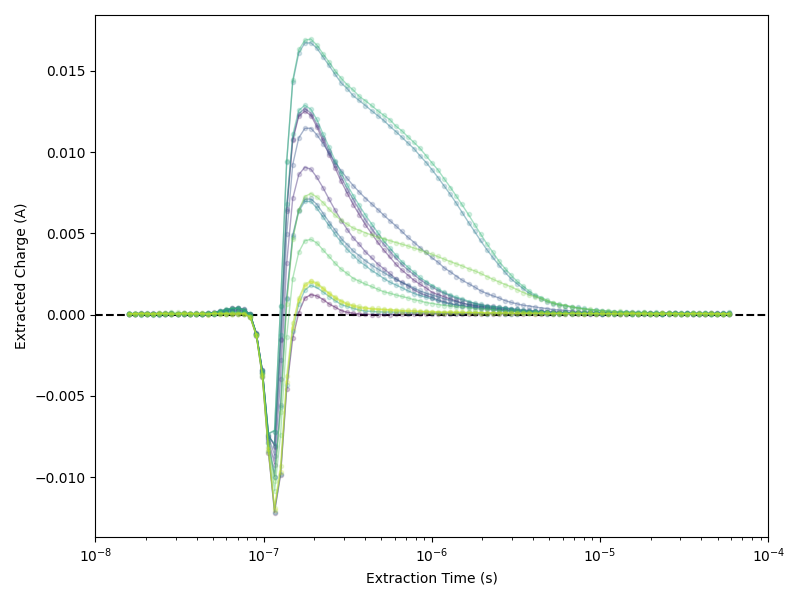

(150, 70, 1) (150, 70, 1)
150 (70, 1) (70, 1)


In [30]:
# configure initial state here.


# dictionary of hyper params
dataset = {
    'trajs': None,
    'times': None,
    'y': None,
    'cut_zero': True # whether to delete all data before t=0
}

dataset_PV = {
    'times': None,
    'power': None,
    'elec_df': r'C:\Users\z5183876\Documents\GitHub\PV-syst-data\Bomen\data_from_server\2021_elec_df.pkl'
    }

model_params = {
    # hyper params

    
    'nhidden': 128,
    'rnn_nhidden': 32,
    'obs_dim': 1,

    'latent_dim': 16,
    'lr': 1e-2,
    'n_batch': 16,
    'beta': 4,

    'optim': None,
    'device': None,
    'func': None,
    'rec': None,
    'dec': None,

    # training params
    'total_epochs_train': 4,
    'epochs_per_train': 2,
    'epochs': 0, # a record of the epochs
    'loss': 0, # loss = KL_loss + MSE loss
    'loss_thresh': 500,
    'MSE_loss': 0,
    'KL_loss': 0,

    #labels
    'name': "default",
    'desc': "default run",
    'folder': "saves"
}

amp = 2
freq = 1
adaptive_training = {
    # change the training parameters during the training procedure, all lists has to have the same length.
    # 'lr': np.logspace(-2, -3, 20),
    'lr': np.logspace(-2.7, -4, 20),
    # 'lr': np.linspace(2e-3, 1e-4, 20),
    'beta': amp*np.sin(np.linspace(0, 5/2*np.pi, 20)) + 2,
    'epochs': [50]*20
}

dataloader(dataset)
trajs = dataset['trajs']
# print(dataset['times'])
# print(dataset['y'])
# print(dataset['trajs'])

obs_dim = trajs[0].size()[1]
model_params['obs_dim'] = obs_dim
# latent_dim, nhidden, rnn_nhidden, obs_dim, lr, n_batch, beta = get_hyper_params(trajs)
# model_params = get_hyper_params(dataset, model_params)
# # func, rec, dec, optim, device, loss, epochs = init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr)
# model_params = init_model(model_params)
# training_loop(func, rec, dec, optim, trajs, times, n_batch, device, beta)

#clear saves folder
# clear_saves()

# dataloader_PV(dataset_PV)

## 2.2. For utility PV data

C:\Users\z5183876\AppData\Local\Temp\ipykernel_23476\906169917.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_data_complete = day_data.reindex(complete_index).fillna(method='pad').fillna(0)
C:\Users\z5183876\AppData\Local\Temp\ipykernel_23476\906169917.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_data_complete = day_data.reindex(complete_index).fillna(method='pad').fillna(0)
C:\Users\z5183876\AppData\Local\Temp\ipykernel_23476\906169917.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_data_complete = day_data.reindex(complete_index).fillna(method='pad').fillna(0)
C:\Users\z5183876\AppData\Local\Temp\ipykernel_23476\906169917.py:40: FutureWarning: Series.fillna with 'method' is deprecated and wi

torch.Size([822, 287, 1]) torch.Size([822, 287, 1])


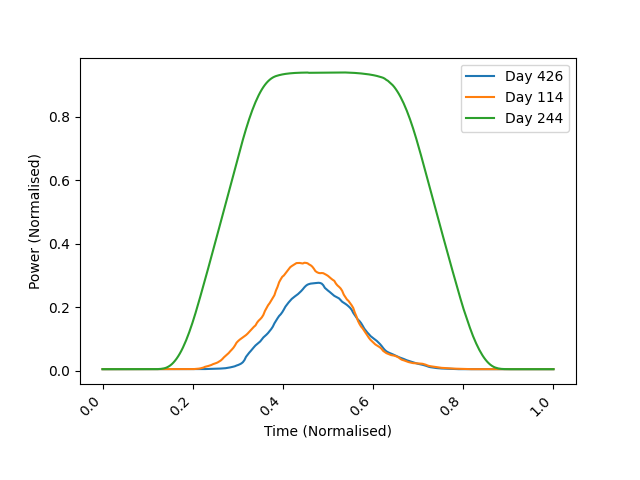

In [31]:
# configure initial state here.


# dictionary of hyper params
dataset = {
    'trajs': None,
    'times': None,
    'y': None,
    'cut_zero': True # whether to delete all data before t=0
}

dataset_PV = {
    'times': None,
    'trajs': None,
    'elec_df': r"C:\Users\z5183876\Documents\GitHub\PV-syst-data\Bomen\data_from_server\bomen-dataset\proc\dtml_days-smpls_poa-temp-wind-pow.pkl",
    'smoothen': True
    }

model_params = {
    # hyper params

    'nhidden': 128,
    'rnn_nhidden': 32,
    'obs_dim': 1,

    'latent_dim': 16,
    'lr': 1e-2,
    'n_batch': 16,
    'beta': 4,

    'optim': None,
    'device': None,
    'func': None,
    'rec': None,
    'dec': None,

    # training params
    'total_epochs_train': 4,
    'epochs_per_train': 2,
    'epochs': 0, # a record of the epochs
    'loss': 0, # loss = KL_loss + MSE loss
    'loss_thresh': 0,
    'MSE_loss': 0,
    'KL_loss': 0,

    #labels
    'name': "default",
    'desc': "default run",
    'folder': "saves"
}

amp = 2
freq = 1
adaptive_training = {
    # change the training parameters during the training procedure, all lists has to have the same length.
    # 'lr': np.logspace(-2, -3, 20),
    'lr': np.logspace(-3, -4, 20),
    # 'lr': np.linspace(2e-3, 1e-4, 20),
    'beta': amp*np.sin(np.linspace(0, 5/2*np.pi, 20)) + 2,
    'epochs': [5]*20
}

dataloader_PV(dataset_PV)
dataset = dataset_PV
daily_power = dataset['trajs']
# print(dataset['times'])
# print(dataset['y'])
# print(dataset['trajs'])
obs_dim = daily_power[0].size()[1]
model_params['obs_dim'] = obs_dim
# latent_dim, nhidden, rnn_nhidden, obs_dim, lr, n_batch, beta = get_hyper_params(trajs)
# model_params = get_hyper_params(dataset, model_params)
# # func, rec, dec, optim, device, loss, epochs = init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr)
# model_params = init_model(model_params)
# training_loop(func, rec, dec, optim, trajs, times, n_batch, device, beta)

#clear saves folder
# clear_saves()

# dataloader_PV(dataset_PV)

# 3.Vanilla way of running code

## 3.1. Execute adaptive training

The adaptive training parameters are: {'lr': array([0.001     , 0.00088587, 0.00078476, 0.00069519, 0.00061585,
       0.00054556, 0.00048329, 0.00042813, 0.00037927, 0.00033598,
       0.00029764, 0.00026367, 0.00023357, 0.00020691, 0.0001833 ,
       0.00016238, 0.00014384, 0.00012743, 0.00011288, 0.0001    ]), 'beta': array([2.        , 2.80339085, 3.47144782, 3.89163448, 3.99316899,
       3.7589475 , 3.22842543, 2.49097097, 1.67081082, 0.90610368,
       0.32566704, 0.02727739, 0.06119947, 0.42171898, 1.04810521,
       1.83484131, 2.64939894, 3.35456314, 3.83154665, 4.        ]), 'epochs': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]}
intialising model on device: cpu


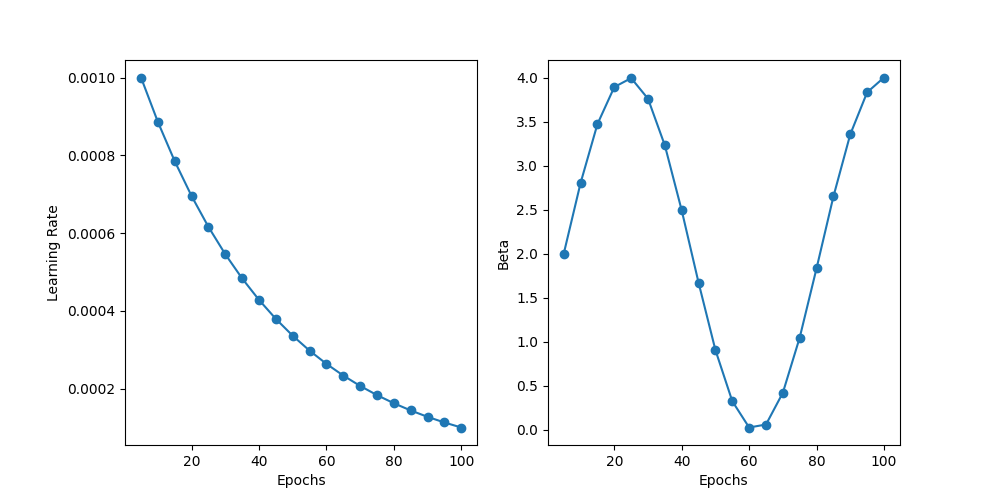

Epoch 1: Total Loss 53.134, KL Loss 0.20, Feat. Loss 52.74
Epoch 1: Total Loss 93.141, KL Loss 0.21, Feat. Loss 92.73
Epoch 1: Total Loss 86.000, KL Loss 0.22, Feat. Loss 85.56
Epoch 1: Total Loss 99.303, KL Loss 0.23, Feat. Loss 98.84
Epoch 1: Total Loss 121.272, KL Loss 0.24, Feat. Loss 120.79
Epoch 1: Total Loss 57.954, KL Loss 0.25, Feat. Loss 57.46
Epoch 1: Total Loss 58.658, KL Loss 0.25, Feat. Loss 58.15
Epoch 1: Total Loss 106.635, KL Loss 0.26, Feat. Loss 106.12
Epoch 1: Total Loss 132.068, KL Loss 0.26, Feat. Loss 131.54
Epoch 1: Total Loss 90.198, KL Loss 0.26, Feat. Loss 89.67
Epoch 1: Total Loss 53.209, KL Loss 0.27, Feat. Loss 52.68
Epoch 1: Total Loss 86.787, KL Loss 0.27, Feat. Loss 86.25
Epoch 1: Total Loss 86.935, KL Loss 0.27, Feat. Loss 86.40
Epoch 1: Total Loss 48.821, KL Loss 0.27, Feat. Loss 48.29
Epoch 1: Total Loss 27.350, KL Loss 0.27, Feat. Loss 26.82
Epoch 1: Total Loss 75.951, KL Loss 0.27, Feat. Loss 75.42
Epoch 1: Total Loss 31.144, KL Loss 0.27, Feat. Lo

C:\Users\z5183876\AppData\Local\Temp\ipykernel_23476\1892511756.py:289: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(MSE_loss, '-r', label='MSE loss', alpha=0.3, color='red')
C:\Users\z5183876\AppData\Local\Temp\ipykernel_23476\1892511756.py:303: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-g" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(KL_loss, '-g', label='KL loss', alpha=0.3, color='green')


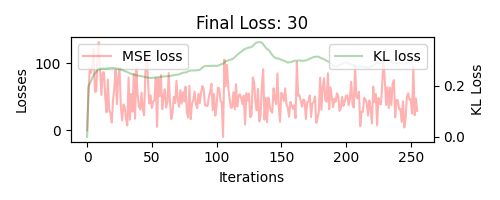

image_arrays shape: (1, 1440, 1920, 4)


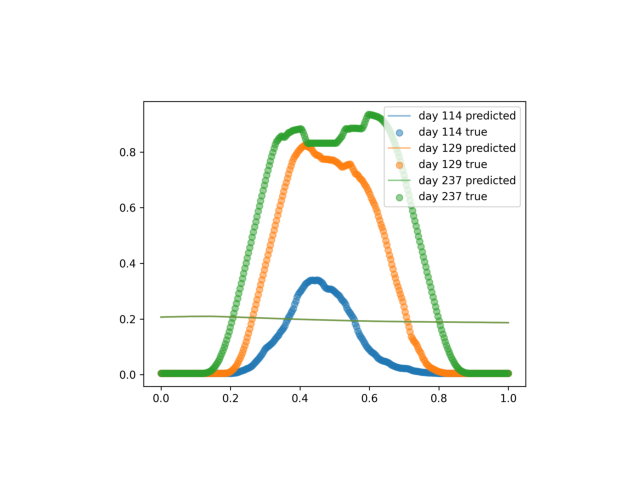

Epoch 1: Total Loss 54.819, KL Loss 0.29, Feat. Loss 54.01
Epoch 1: Total Loss 47.039, KL Loss 0.28, Feat. Loss 46.24
Epoch 1: Total Loss 42.312, KL Loss 0.28, Feat. Loss 41.53
Epoch 1: Total Loss 13.512, KL Loss 0.28, Feat. Loss 12.74
Epoch 1: Total Loss 11.636, KL Loss 0.27, Feat. Loss 10.87
Epoch 1: Total Loss 75.582, KL Loss 0.27, Feat. Loss 74.83
Epoch 1: Total Loss 82.516, KL Loss 0.27, Feat. Loss 81.77
Epoch 1: Total Loss 49.610, KL Loss 0.26, Feat. Loss 48.87
Epoch 1: Total Loss 90.073, KL Loss 0.26, Feat. Loss 89.34
Epoch 1: Total Loss 27.455, KL Loss 0.26, Feat. Loss 26.72
Epoch 1: Total Loss 32.125, KL Loss 0.26, Feat. Loss 31.38
Epoch 1: Total Loss 46.556, KL Loss 0.26, Feat. Loss 45.82
Epoch 1: Total Loss 45.741, KL Loss 0.26, Feat. Loss 45.00
Epoch 1: Total Loss 18.789, KL Loss 0.26, Feat. Loss 18.05
Epoch 1: Total Loss 26.172, KL Loss 0.26, Feat. Loss 25.43
Epoch 1: Total Loss 33.270, KL Loss 0.26, Feat. Loss 32.53
Epoch 1: Total Loss 39.284, KL Loss 0.27, Feat. Loss 38.

C:\Users\z5183876\AppData\Local\Temp\ipykernel_23476\1892511756.py:289: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(MSE_loss, '-r', label='MSE loss', alpha=0.3, color='red')
C:\Users\z5183876\AppData\Local\Temp\ipykernel_23476\1892511756.py:303: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-g" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(KL_loss, '-g', label='KL loss', alpha=0.3, color='green')


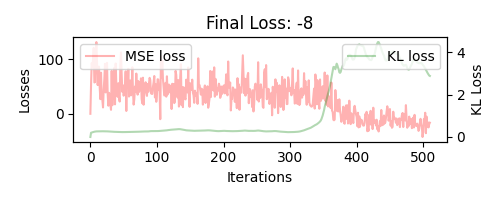

image_arrays shape: (2, 1440, 1920, 4)


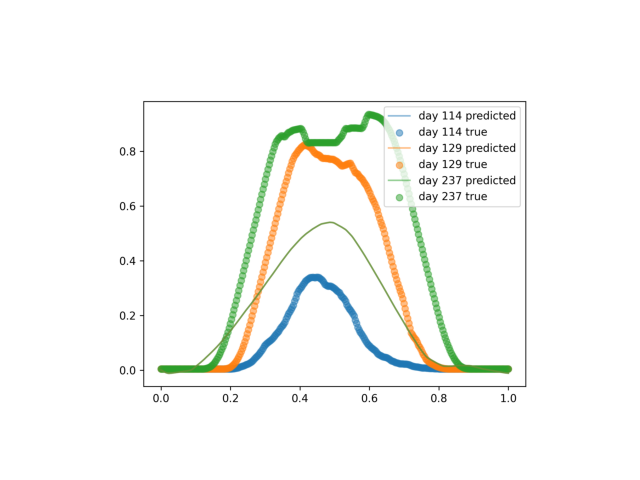

Training is done


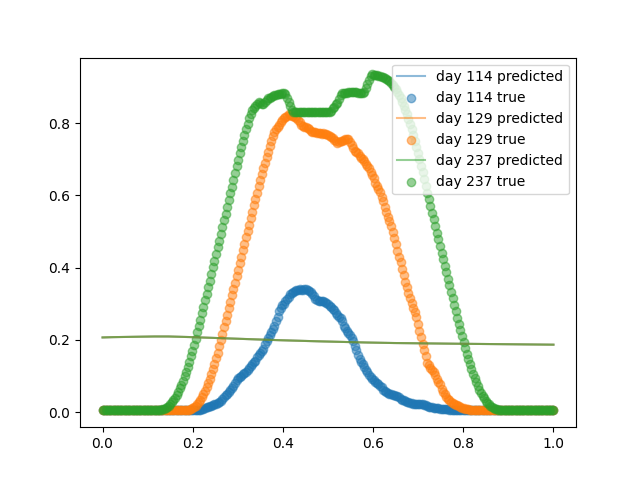

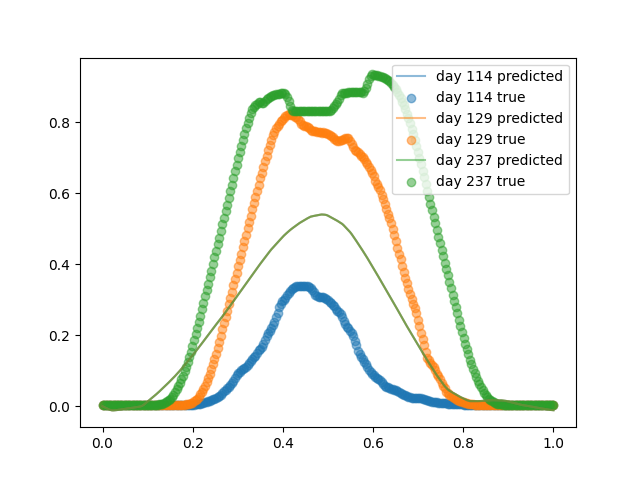

In [32]:
adaptive_run_and_save(model_params, dataset, adaptive_training)

## 3.2. Execute a grid search

The model parameters are: {'nhidden': 128, 'rnn_nhidden': 32, 'obs_dim': 1, 'latent_dim': 2, 'lr': 0.01, 'n_batch': 16, 'beta': 4, 'optim': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), 'device': 'cpu', 'func': LatentODEfunc(
  (elu): ELU(alpha=1.0, inplace=True)
  (fci): Linear(in_features=16, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fco): Linear(in_features=128, out_features=16, bias=True)
), 'rec': RecognitionRNN(
  (i2h): Linear(in_features=33, out_features=32, bias=True)
  (h2o): Linear(in_features=32, out_features=32, bias=True)
), 'dec': Decoder(
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
), 'total_epochs_train': 10, 'epochs_per_train': 2, 'epochs':

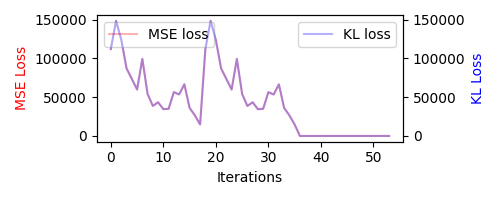

Epoch 1: Total Loss 17154.164, KL Loss 13.13, Feat. Loss 17101.64
Epoch 1: Total Loss 38941.508, KL Loss 18.39, Feat. Loss 38867.95
Epoch 1: Total Loss 22669.293, KL Loss 17.96, Feat. Loss 22597.47
Epoch 1: Total Loss 7859.785, KL Loss 16.12, Feat. Loss 7795.32
Epoch 1: Total Loss 36585.863, KL Loss 26.18, Feat. Loss 36481.14
Epoch 1: Total Loss 35687.367, KL Loss 29.32, Feat. Loss 35570.08
Epoch 1: Total Loss 23024.387, KL Loss 24.74, Feat. Loss 22925.43
Epoch 1: Total Loss 19479.578, KL Loss 31.11, Feat. Loss 19355.13
Epoch 1: Total Loss 33727.207, KL Loss 30.53, Feat. Loss 33605.09
Epoch 1 : 1567.53, 1439.02
Epoch 2: Total Loss 12697.400, KL Loss 21.05, Feat. Loss 12613.21
Epoch 2: Total Loss 13687.146, KL Loss 20.03, Feat. Loss 13607.03
Epoch 2: Total Loss 6175.909, KL Loss 19.64, Feat. Loss 6097.35
Epoch 2: Total Loss 12744.781, KL Loss 16.84, Feat. Loss 12677.44
Epoch 2: Total Loss 23210.037, KL Loss 17.80, Feat. Loss 23138.85
Epoch 2: Total Loss 18393.471, KL Loss 16.08, Feat. L

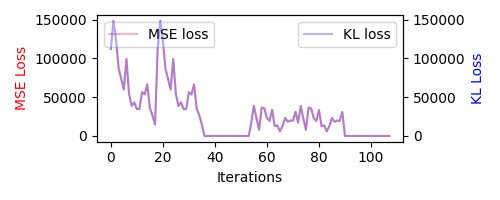

Epoch 1: Total Loss 15597.688, KL Loss 16.94, Feat. Loss 15529.92
Epoch 1: Total Loss 4603.218, KL Loss 17.80, Feat. Loss 4532.03
Epoch 1: Total Loss 23834.428, KL Loss 14.21, Feat. Loss 23777.61
Epoch 1: Total Loss 21249.842, KL Loss 15.39, Feat. Loss 21188.29
Epoch 1: Total Loss 9564.452, KL Loss 13.33, Feat. Loss 9511.13
Epoch 1: Total Loss 7946.814, KL Loss 15.37, Feat. Loss 7885.32
Epoch 1: Total Loss 14387.093, KL Loss 17.71, Feat. Loss 14316.27
Epoch 1: Total Loss 14881.318, KL Loss 17.06, Feat. Loss 14813.08
Epoch 1: Total Loss 9229.791, KL Loss 18.54, Feat. Loss 9155.62
Epoch 1 : 808.63, 899.19
Epoch 2: Total Loss 14156.646, KL Loss 20.12, Feat. Loss 14076.16
Epoch 2: Total Loss 5860.368, KL Loss 13.81, Feat. Loss 5805.14
Epoch 2: Total Loss 6400.264, KL Loss 13.42, Feat. Loss 6346.57
Epoch 2: Total Loss 31968.479, KL Loss 18.52, Feat. Loss 31894.39
Epoch 2: Total Loss 5125.890, KL Loss 10.53, Feat. Loss 5083.76
Epoch 2: Total Loss 7211.875, KL Loss 18.72, Feat. Loss 7137.00
E

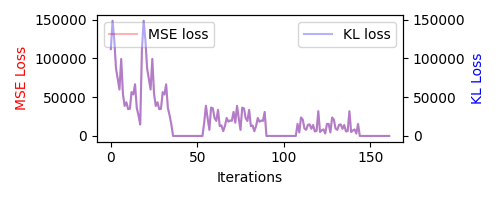

Epoch 1: Total Loss 9274.085, KL Loss 17.11, Feat. Loss 9205.64
Epoch 1: Total Loss 8416.079, KL Loss 14.38, Feat. Loss 8358.57
Epoch 1: Total Loss 10570.858, KL Loss 15.42, Feat. Loss 10509.16
Epoch 1: Total Loss 6450.667, KL Loss 17.17, Feat. Loss 6381.98
Epoch 1: Total Loss 6913.176, KL Loss 15.02, Feat. Loss 6853.09
Epoch 1: Total Loss 10974.697, KL Loss 21.19, Feat. Loss 10889.92
Epoch 1: Total Loss 6374.309, KL Loss 15.07, Feat. Loss 6314.02
Epoch 1: Total Loss 8981.253, KL Loss 19.01, Feat. Loss 8905.21
Epoch 1: Total Loss 4716.313, KL Loss 13.25, Feat. Loss 4663.29
Epoch 1 : 484.48, 526.00
Epoch 2: Total Loss 10517.582, KL Loss 17.43, Feat. Loss 10447.87
Epoch 2: Total Loss 3212.732, KL Loss 15.85, Feat. Loss 3149.34
Epoch 2: Total Loss 4241.135, KL Loss 12.09, Feat. Loss 4192.76
Epoch 2: Total Loss 1597.740, KL Loss 9.36, Feat. Loss 1560.31
Epoch 2: Total Loss 11437.831, KL Loss 16.89, Feat. Loss 11370.25
Epoch 2: Total Loss 5441.925, KL Loss 12.55, Feat. Loss 5391.74
Epoch 2:

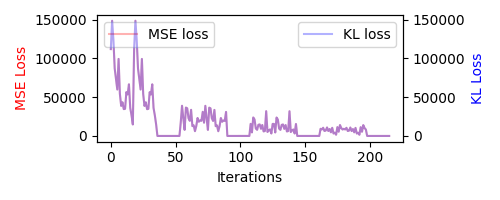

Epoch 1: Total Loss 5087.688, KL Loss 11.02, Feat. Loss 5043.61
Epoch 1: Total Loss 10522.902, KL Loss 13.96, Feat. Loss 10467.05
Epoch 1: Total Loss 12486.964, KL Loss 15.92, Feat. Loss 12423.28
Epoch 1: Total Loss 6843.114, KL Loss 17.79, Feat. Loss 6771.97
Epoch 1: Total Loss 6979.432, KL Loss 18.11, Feat. Loss 6906.99
Epoch 1: Total Loss 10427.046, KL Loss 17.33, Feat. Loss 10357.72
Epoch 1: Total Loss 5734.251, KL Loss 17.45, Feat. Loss 5664.43
Epoch 1: Total Loss 6436.203, KL Loss 15.40, Feat. Loss 6374.60
Epoch 1: Total Loss 16429.344, KL Loss 15.11, Feat. Loss 16368.89
Epoch 1 : 539.65, 436.21
Epoch 2: Total Loss 16205.884, KL Loss 15.43, Feat. Loss 16144.15
Epoch 2: Total Loss 6375.411, KL Loss 15.75, Feat. Loss 6312.40
Epoch 2: Total Loss 3582.637, KL Loss 13.98, Feat. Loss 3526.72
Epoch 2: Total Loss 7185.169, KL Loss 14.75, Feat. Loss 7126.17
Epoch 2: Total Loss 3331.845, KL Loss 17.11, Feat. Loss 3263.40
Epoch 2: Total Loss 8311.840, KL Loss 22.62, Feat. Loss 8221.36
Epoch

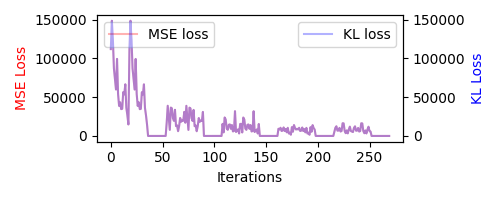

./saves/grid_seach/search2/lr_0.01_nb_16_ld_2_b_4_default_20240312-122639/*.png
image_arrays shape: (5, 1200, 2100, 4)


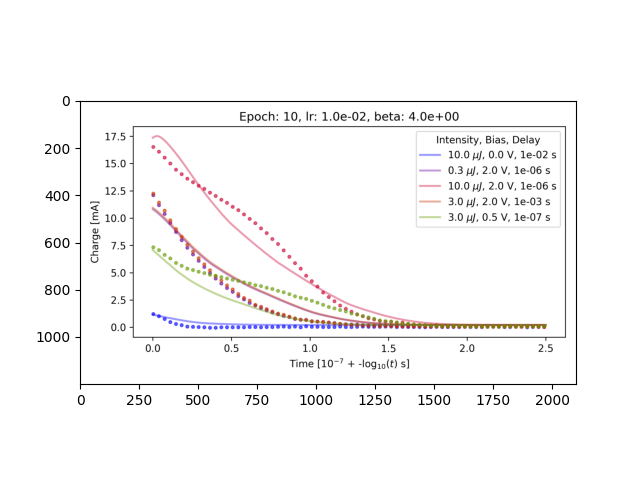

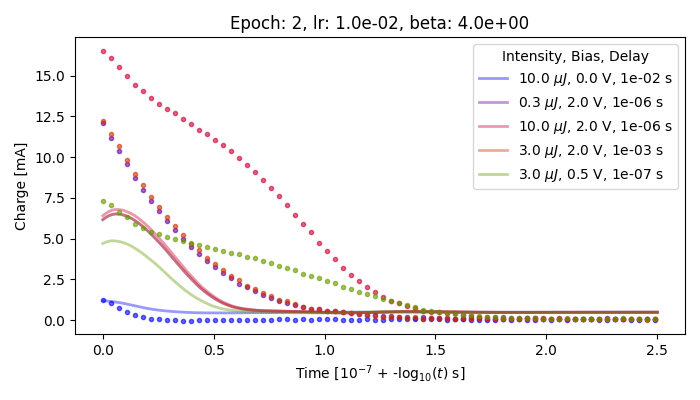

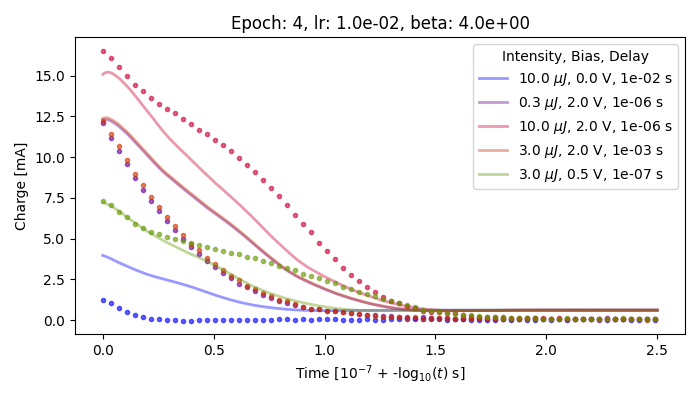

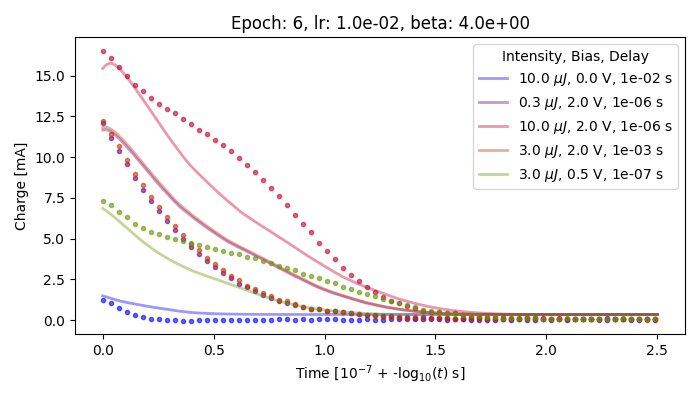

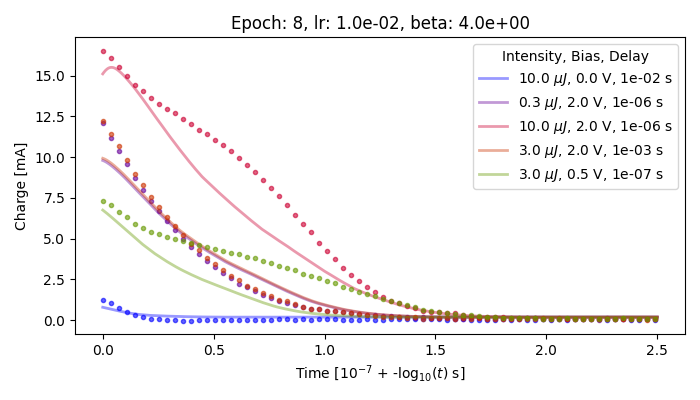

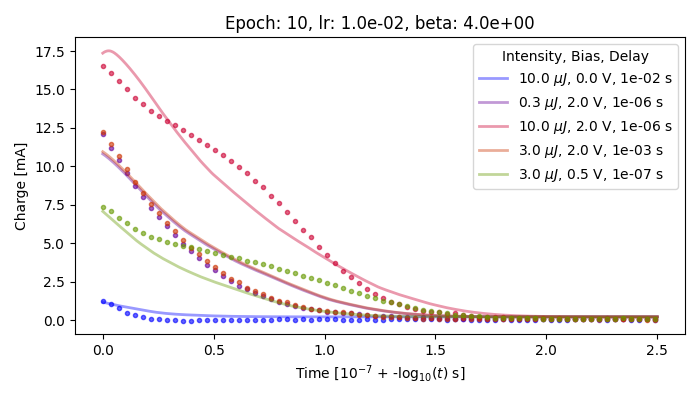

In [ ]:
grid_search(model_params)

## 3.3. Run and save

In [1]:
run_and_save(model_params, dataset)

NameError: name 'run_and_save' is not defined

## 3.4. Others

In [ ]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 369A-61BF

 Directory of c:\Users\z5183876\Documents\GitHub\ML_charge_modeling\nbks

12/03/2024  11:15 AM    <DIR>          .
12/03/2024  08:31 AM    <DIR>          ..
12/03/2024  08:22 AM    <DIR>          gifs
12/03/2024  12:14 PM         2,827,579 parameter_tuning.ipynb
12/03/2024  08:22 AM           498,255 ray.ipynb
12/03/2024  12:28 PM    <DIR>          saves
12/03/2024  08:23 AM         2,196,743 trce-lode-rebuild.ipynb
12/03/2024  08:23 AM           202,975 trce-process-updt.ipynb
               4 File(s)      5,725,552 bytes
               4 Dir(s)  321,914,171,392 bytes free


In [ ]:
#interpret grid search results

dataframe1 = pd.read_excel(".\saves\grid_seach\search1\excel_output\summary.xlsx")
 
# print(dataframe1)
data_dict = dataframe1.to_dict()

size = len(data_dict['Unnamed: 0'])
indexes = data_dict['Unnamed: 0']
learning_rates = data_dict['learning rate']
n_batchs = data_dict['n_batch']
latent_dims = data_dict['latent_dim']
betas = data_dict['beta']
lowest_loss = data_dict['lowest_loss']



minimum_loss = min(lowest_loss.values())
minimum_loss_index = list(lowest_loss.values()).index(minimum_loss)
print(f"minimum_loss: {minimum_loss} at index: {minimum_loss_index} with learning rate: {learning_rates[minimum_loss_index]}, n_batch: {n_batchs[minimum_loss_index]}, latent_dim: {latent_dims[minimum_loss_index]}, beta: {betas[minimum_loss_index]}")

lowest_loss_sorted = sorted(list(lowest_loss.values()))[:5]      #gets the 5 lowest loss values
lowest_loss_index = [list(lowest_loss.values()).index(i) for i in lowest_loss_sorted]  #gets the indexes of the 5 lowest loss values
print("\n Analysing the 5 lowest values: \n")
for i in lowest_loss_index:
    print(f"loss: {lowest_loss[i]} at index: {i} with learning rate: {learning_rates[i]}, n_batch: {n_batchs[i]}, latent_dim: {latent_dims[i]}, beta: {betas[i]}")

print("\n analysing average loss of each characterstic \n")

#get unique values of each characteristic
unique_learning_rates = list(set(learning_rates.values()))
unique_n_batchs = list(set(n_batchs.values()))
unique_latent_dims = list(set(latent_dims.values()))
unique_betas = list(set(betas.values()))\

best_learning_rate = unique_learning_rates[0]
max_loss = max(lowest_loss.values())

temp_min = max_loss
temp_avg = max_loss
best_learning_rate_min = 0
best_learning_rate_avg = 0
for lr in unique_learning_rates:
    lr_losses = [lowest_loss[i] for i in range(size) if learning_rates[i] == lr]
    print(f"\nanalysing learning rate: {lr}\n")
    minimum = min(lr_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(lr_losses, 25)}")
    mean = sum(lr_losses)/len(lr_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(lr_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_learning_rate_min = lr
    if mean < temp_avg:
        temp_avg = mean
        best_learning_rate_avg = lr
print(f"\nbest learning rate for minimum loss: {best_learning_rate_min}")
print(f"best learning rate for average loss: {best_learning_rate_avg}\n")
    
temp_min = max_loss
temp_avg = max_loss
best_n_batch_min = 0
best_n_batch_avg = 0
for nb in unique_n_batchs:
    nb_losses = [lowest_loss[i] for i in range(size) if n_batchs[i] == nb]
    print(f"\nanalysing n_batch: {nb}\n")
    minimum = min(nb_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(nb_losses, 25)}")
    mean = sum(nb_losses)/len(nb_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(nb_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_n_batch_min = nb
    if mean < temp_avg:
        temp_avg = mean
        best_n_batch_avg = nb
print(f"\nbest n_batch for minimum loss: {best_n_batch_min}")
print(f"best n_batch for average loss: {best_n_batch_avg}\n")

temp_min = max_loss
temp_avg = max_loss
best_latent_dim_min = 0
best_latent_dim_avg = 0
for ld in unique_latent_dims:
    ld_losses = [lowest_loss[i] for i in range(size) if latent_dims[i] == ld]
    print(f"\nanalysing latent_dim: {ld}\n")
    minimum = min(ld_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(ld_losses, 25)}")
    mean = sum(ld_losses)/len(ld_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(ld_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_latent_dim_min = ld
    if mean < temp_avg:
        temp_avg = mean
        best_latent_dim_avg = ld
print(f"\nbest latent_dim for minimum loss: {best_latent_dim_min}")
print(f"best latent_dim for average loss: {best_latent_dim_avg}\n")


temp_min = max_loss
temp_avg = max_loss
best_beta_min = 0
best_beta_avg = 0
for b in unique_betas:
    b_losses = [lowest_loss[i] for i in range(size) if betas[i] == b]
    print(f"\nanalysing beta: {b}\n")
    minimum = min(b_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(b_losses, 25)}")
    mean = sum(b_losses)/len(b_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(b_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_beta_min = b
    if mean < temp_avg:
        temp_avg = mean
        best_beta_avg = b
print(f"\nbest beta for minimum loss: {best_beta_min}")
print(f"best beta for average loss: {best_beta_avg}\n")

minimum_loss: 8813.390625 at index: 20 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.001

 Analysing the 5 lowest values: 

loss: 8813.390625 at index: 20 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.001
loss: 13821.625 at index: 9 with learning rate: 0.01, n_batch: 16, latent_dim: 2, beta: 4.0
loss: 14612.8681640625 at index: 16 with learning rate: 0.01, n_batch: 16, latent_dim: 8, beta: 0.5
loss: 15689.7685546875 at index: 46 with learning rate: 0.005, n_batch: 16, latent_dim: 16, beta: 0.5
loss: 16143.001953125 at index: 21 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.5

 analysing average loss of each characterstic 


analysing learning rate: 0.01

minimum loss: 8813.390625
25th percentile: 17082.22265625
average loss: 36204.0650390625
75th percentile loss: 51540.1328125

analysing learning rate: 0.005

minimum loss: 15689.7685546875
25th percentile: 18697.85546875
average loss: 33086.3885546875
75th percentile loss: 23377.257812

In [ ]:
# change summary avg loss -> 25%
# summary to include what the bads are.
# take the interesting examples/trends and look into them
# implement MSE/KL graphs.

# implement time-cutoff and run interesting trends at 200 epochs
# tweak/look into a or f tolerance

# start working on report. 


# loss: 13821.625 at index: 9 with learning rate: 0.01, n_batch: 16, latent_dim: 2, beta: 4.0

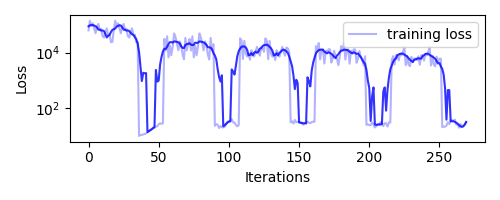

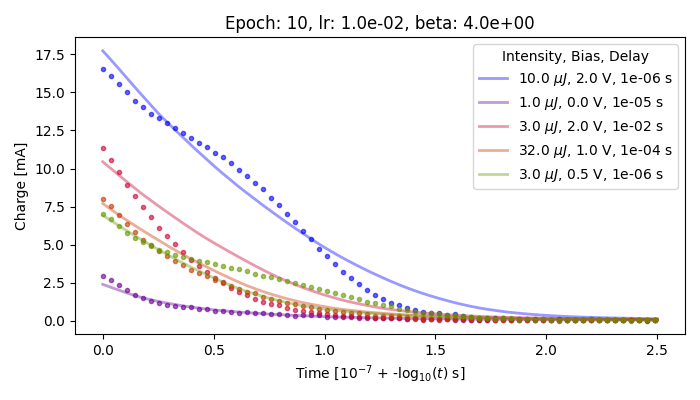

In [ ]:
plot_training_loss(model_params)
display_random_fit(model_params, dataset)

(150, 2) (150, 1000, 2)


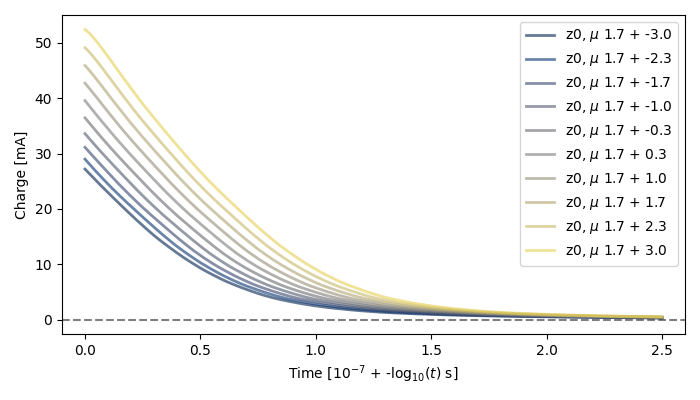

(150, 2) (150, 1000, 2)


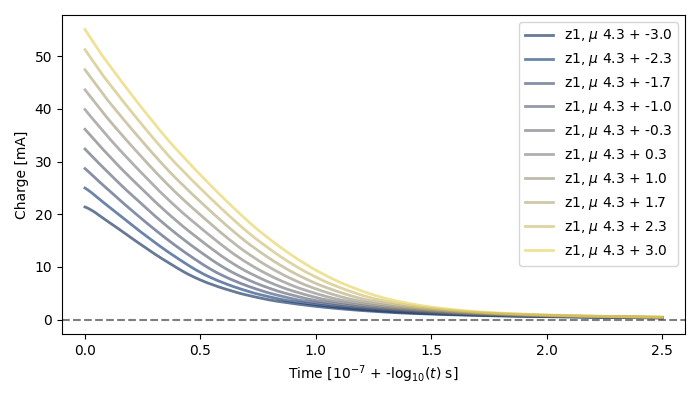

In [ ]:
sweep_latent_adaptives(model_params, dataset)

./saves/lr_0.01_nb_16_ld_2_b_4_default_20240312-122816/*.png
image_arrays shape: (5, 1200, 2100, 4)


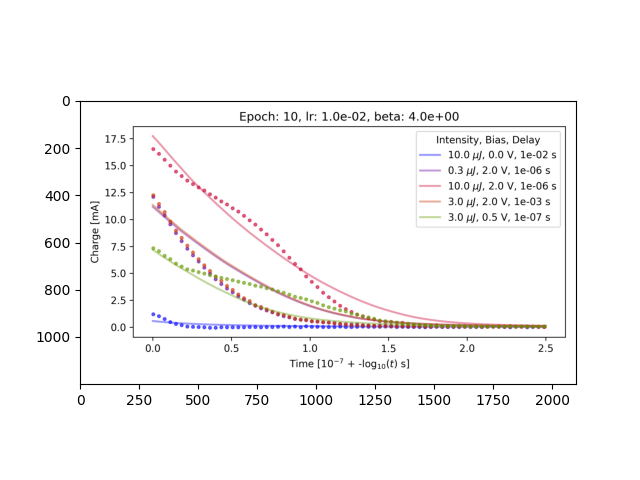

In [ ]:
compile_learning_gif(model_params)

select fixed subset to sample in gif
save the model
record params
plot param changes along with gif
remove 1 second bias
